In [1]:
import pandas as pd
import yfinance as yf
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [8]:
df_log_returns = pd.read_csv('sp500_log_returns.csv', index_col=0, parse_dates=True)
df_price = pd.read_csv('sp500_data_cleaned.csv', index_col=0, parse_dates=True)
df_corr = df_log_returns.corr()
df_cov = df_log_returns.cov() *252  # Annualize the covariance matrix
avg_returns = df_log_returns.mean() * 252  # Annualize the average returns
stocks = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'TSLA', 'META']
risk_free_rate = 0.02 # 2% risk-free rate


# Efficient Frontier
Calculate portfolio **Risk** given differnt weights of stocks in a portfolio

$\sigma_{portfolio}^2 = w^T \cdot \Sigma \cdot w$ <br>

$\Sigma$ is the covaraince matrix <br>
$w$ is the weight of the stocks in the portfolio matrix

In [ ]:

num_portfolios = 5000

p_ret = [] # Portfolio Returns
p_vol = [] # Portfolio Volatility (Risk)
p_weights = [] # Save the weights so we can look up the best one later
num_stocks = len(stocks)

for portfolio in range(num_portfolios):
    #Genertae Random Weights
    weight = np.random.random(num_stocks)
    weight /= np.sum(weight) #Normalize to 1
    p_weights.append(weight)

    # Calculate Return (Reward)
    # Simple weighted average: (Weight A * Ret A) + (Weight B * Ret B)...
    returns = np.dot(weight, avg_returns[stocks])
    p_ret.append(returns)

    #Calculate Volatility (Risk)
    variance = weight.T @ df_cov.loc[stocks, stocks] @ weight

    volatility = np.sqrt(variance)
    p_vol.append(volatility)

data = {'Returns': p_ret, 'Volatility': p_vol}

<Axes: xlabel='Volatility', ylabel='Returns'>

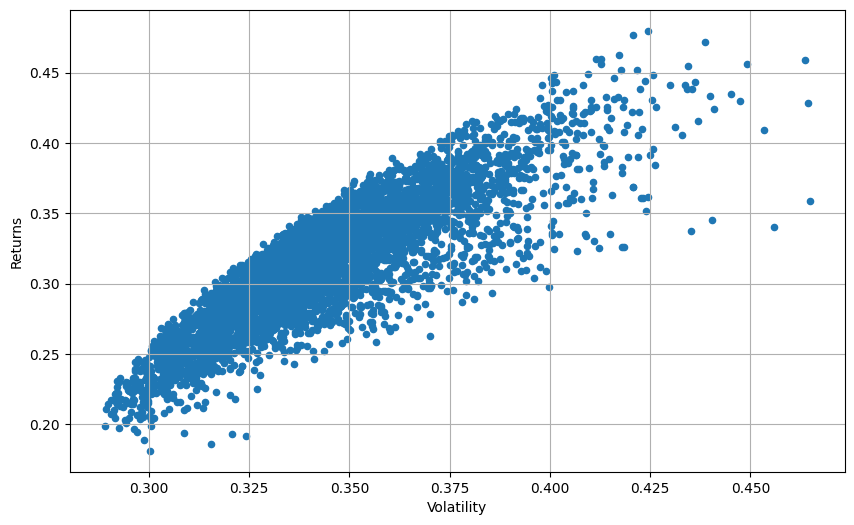

In [4]:
data_df = pd.DataFrame(data)
data_df.plot.scatter(x='Volatility', y='Returns', figsize=(10, 6), grid=True)

## Finding optimal Risk:Reward Portfolio
Using Sharpe Ratio

In [ ]:
data_df["Sharpe Ratio"] = (data_df["Returns"] - risk_free_rate) / data_df["Volatility"]
data_df.head()

,Returns,Volatility,Sharpe Ratio
0,0.318918,0.337635,0.885327
1,0.281839,0.334088,0.783742
2,0.320631,0.370770,0.810830
3,0.324972,0.344392,0.885537
4,0.412710,0.419183,0.936847


In [6]:
#highest sharpe ratio
max_sharpe_port = data_df.iloc[data_df['Sharpe Ratio'].idxmax()]
print(f"Returns: {np.e**max_sharpe_port['Returns'] -1:.2%}\nVolatility: {max_sharpe_port['Volatility']}\n")
max_sharpe_weights = p_weights[data_df['Sharpe Ratio'].idxmax()]

for i in range(len(stocks)):
    print(f"{stocks[i]}: {max_sharpe_weights[i]:.2%}")




Returns: 61.09%
Volatility: 0.42068204137261256

AAPL: 17.44%
MSFT: 5.06%
GOOGL: 5.74%
AMZN: 6.78%
TSLA: 6.44%
NVDA: 58.54%


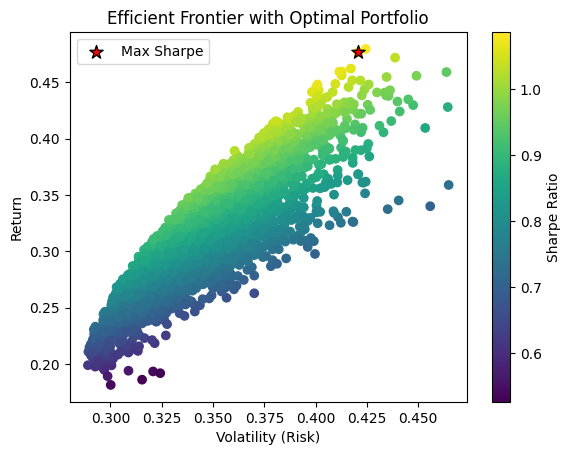

In [7]:
plt.scatter(data_df['Volatility'], data_df['Returns'], c=data_df['Sharpe Ratio'], cmap='viridis')
plt.colorbar(label='Sharpe Ratio')
plt.scatter(max_sharpe_port['Volatility'], max_sharpe_port['Returns'], c='red', s=100, marker='*', edgecolors='black', label='Max Sharpe')
plt.title('Efficient Frontier with Optimal Portfolio')
plt.xlabel('Volatility (Risk)')
plt.ylabel('Return')
plt.legend()
plt.show()

## Optimize the Sharpe Ratio and find stock ratios

In [16]:
from scipy.optimize import minimize

def neg_sharpe_ratio(weights, stocks, df_cov, avg_returns, risk_free_rate=risk_free_rate):
    returns = np.dot(weights, avg_returns[stocks])
    variance = weights.T @ df_cov.loc[stocks, stocks] @ weights
    volatility = np.sqrt(variance)
    sharpe_ratio = (returns - risk_free_rate) / volatility
    return -sharpe_ratio

num_stocks = len(stocks)
#setting the rules/constraints
# 'eq' means "Equality constraint", 'fun' means the function must equal 0
constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1}) #weights must sum to 1

# Create a bound (0,1) for every single stock in your list
#NO SHORTING
bounds = tuple((0, 1) for _ in range(num_stocks)) #weights

#Initial Guess (Equal Distribution)
init_guess = num_stocks * [1. / num_stocks, ]

opt_results = minimize(neg_sharpe_ratio, #function to optimize
                       init_guess,  #inital guess
                       method='SLSQP', #specific algorithm
                       args=(stocks, df_cov, avg_returns, risk_free_rate), #extra arguments for the function
                       bounds=bounds, #limits for each weight (0-100%)
                       constraints=constraints) #the rules where all weights must sum to 1
print("Optimized Portfolio Weights:")
for i in range(len(stocks)):
    print(f"{stocks[i]}: {opt_results.x[i]:.2%}")


Optimized Portfolio Weights:
AAPL: 48.59%
MSFT: 24.76%
GOOGL: 0.00%
AMZN: 0.00%
TSLA: 26.65%
META: 0.00%


In [11]:
#Optimization program from scratch

#function to maximize
def get_sharpe(weights, avg_returns=avg_returns, cov_matrix=df_cov, risk_free_rate=risk_free_rate, stocks=stocks):
    weights = np.array(weights)

    returns = np.dot(weights, avg_returns[stocks])
    
    #Calculate Volatility (Risk)
    variance = weights.T @ cov_matrix.loc[stocks, stocks] @ weights

    volatility = np.sqrt(variance)

    return (returns-risk_free_rate) / volatility

#calculates the gradient for one small change in 1 stock
#akin to a compass to see which direction is UP
def get_gradient(weights, stocks, avg_returns=avg_returns, cov_matrix=df_cov, delta=1e-5):
    original_sharpe = get_sharpe(weights, stocks=stocks) #Get the inital sharpe based on current weights
        #this will most likely be equally distributed weights
    
    grads = np.zeros(len(weights)) # 0 array to hold the gradients(slopes) for each weight
    
    for i in range(len(weights)): # for each weight
        w_perturbed = weights.copy()
        w_perturbed[i] += delta #Increase the weight for one stock by a very small number delta(0.00001)

        #calculate the new sharpe ratio and see how it changed
        new_sharpe = get_sharpe(weights=w_perturbed, stocks=stocks)

        #calculate the slope for the weight
        grads[i] = (new_sharpe-original_sharpe) / delta

    return grads

def optimize_portfolio(stocks, avg_returns=avg_returns, cov_matrix=df_cov, learning_rate=0.1, iterations=1000):
    num_assests = len(stocks)

    #start with equally distributed weights
    weights = np.array([1.0/num_assests]*num_assests)

    for i in range(iterations):
        #find the gradient
        grads = get_gradient(weights=weights, stocks=stocks)

        #take a step UPWARDS(ascent)
        weights = weights +(grads *learning_rate)

        #Size of each step is determined by learning rate
        #Higher learning rate = bigger steps but can overshoot - quicker results but incorrect since itll overshoot everything it tries to optimize
        #Lower learning rate = smaller steps but more precise - slower results or incorrent results in not ran long enough

        #--------- Constraints

        #Ensure that all weights are 0 or higher
        #so no shorting
        weights[weights<0] = 0

        #negative numbers are typically referred to as a negative weight 
        #bc it indicates a short position since you are selling something you do not own
    

        #normalize the weights
        weights = weights / np.sum(weights)

        if i % 500 == 0:
            current_sharpe = get_sharpe(weights=weights, stocks=stocks)
            print(f"Step {i}: Sharpe = {current_sharpe:.4f}")

    return weights




In [30]:
tickers = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'TSLA', 'META']

opt_weights = optimize_portfolio(stocks=tickers, learning_rate=0.01, iterations=5000, avg_returns=avg_returns, cov_matrix=df_cov)
print("Optimized Portfolio Weights (From Scratch):")
for i in range(len(tickers)):
    print(f"{tickers[i]}: {opt_weights[i]:.2%}")

Step 0: Sharpe = 0.7017
Step 500: Sharpe = 0.7940
Step 1000: Sharpe = 0.7950
Step 1500: Sharpe = 0.7951
Step 2000: Sharpe = 0.7951
Step 2500: Sharpe = 0.7951
Step 3000: Sharpe = 0.7951
Step 3500: Sharpe = 0.7951
Step 4000: Sharpe = 0.7951
Step 4500: Sharpe = 0.7951
Optimized Portfolio Weights (From Scratch):
AAPL: 39.06%
MSFT: 26.89%
GOOGL: 6.38%
AMZN: 0.00%
TSLA: 27.17%
META: 0.49%


In [20]:
#Comparing my function vs SciPy function

tickers = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'TSLA', 'META', "DELL", "IBM", "ORCL"]
num_stocks = len(tickers)
print("\nComparing Optimization from Scratch vs SciPy Optimize:\n")
opt_weights_scratch = optimize_portfolio(stocks=tickers, 
                                         learning_rate=0.01, 
                                         iterations=3000, 
                                         avg_returns=avg_returns, 
                                         cov_matrix=df_cov)

constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1}) #weights must sum to 1
bounds = tuple((0, 1) for _ in range(num_stocks)) #weights
init_guess = num_stocks * [1. / num_stocks, ]

opt_results_scipy = minimize(neg_sharpe_ratio, #function to optimize
                       init_guess,  #inital guess
                       method='SLSQP', #specific algorithm
                       args=(tickers, df_cov, avg_returns, risk_free_rate), #extra arguments for the function
                       bounds=bounds, #limits for each weight (0-100%)
                       constraints=constraints) #the rules where all weights must sum to 1

for i in range(len(tickers)):
    print(f"{tickers[i]} - From Scratch: {opt_weights_scratch[i]:.2%}, From SciPy: {opt_results_scipy.x[i]:.2%}")



Comparing Optimization from Scratch vs SciPy Optimize:

Step 0: Sharpe = 0.8258
Step 500: Sharpe = 0.9658
Step 1000: Sharpe = 0.9658
Step 1500: Sharpe = 0.9658
Step 2000: Sharpe = 0.9658
Step 2500: Sharpe = 0.9658
AAPL - From Scratch: 14.72%, From SciPy: 11.54%
MSFT - From Scratch: 0.00%, From SciPy: 0.00%
GOOGL - From Scratch: 0.00%, From SciPy: 0.00%
AMZN - From Scratch: 0.00%, From SciPy: 0.00%
TSLA - From Scratch: 17.21%, From SciPy: 17.67%
META - From Scratch: 0.00%, From SciPy: 0.00%
DELL - From Scratch: 22.95%, From SciPy: 24.29%
IBM - From Scratch: 13.74%, From SciPy: 9.04%
ORCL - From Scratch: 31.39%, From SciPy: 37.46%
